In [ ]:
import pandas as pd
import numpy as np
from keras.preprocessing import sequence
from keras.layers import TimeDistributed, GlobalAveragePooling1D, GlobalAveragePooling2D, BatchNormalization
#from keras.layers.recurrent import LSTM
from tensorflow.keras.layers import LSTM
#from keras.layers.convolutional import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, AveragePooling1D
#from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import Embedding
#from keras.layers import Dropout, Flatten, Bidirectional, Dense, Activation, TimeDistributed
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, AveragePooling1D
from tensorflow.keras.layers import Embedding, Dropout, Flatten, Bidirectional, Dense, Activation, TimeDistributed
from keras.models import Model, Sequential
#from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from string import ascii_lowercase
from collections import Counter
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models import doc2vec
from gensim.models import KeyedVectors
import itertools, nltk, snowballstemmer, re
from gensim.models.doc2vec import TaggedDocument

LabeledSentence = doc2vec.TaggedDocument

In [ ]:
class LabeledLineSentence(object):
    def __init__(self, sources):
        self.sources = sources

        flipped = {}

        # make sure that keys are unique
        for key, value in sources.items():
            if value not in flipped:
                flipped[value] = [key]
            else:
                raise Exception('Non-unique prefix encountered')

    def __iter__(self):
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    yield LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no])

    def to_array(self):
        self.sentences = []
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    self.sentences.append(LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no]))
        return self.sentences

    def sentences_perm(self):
        shuffled = list(self.sentences)
        random.shuffle(shuffled)
        return shuffled

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#data = pd.read_csv('deceptive-opinion-spam-corpus.zip', compression='zip', header=0, sep=',', quotechar='"')
data = pd.read_csv("/content/drive/MyDrive/FILES/deceptive-opinion.csv")

In [ ]:
data.head()

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...
4,truthful,hyatt,positive,TripAdvisor,I asked for a high floor away from the elevato...


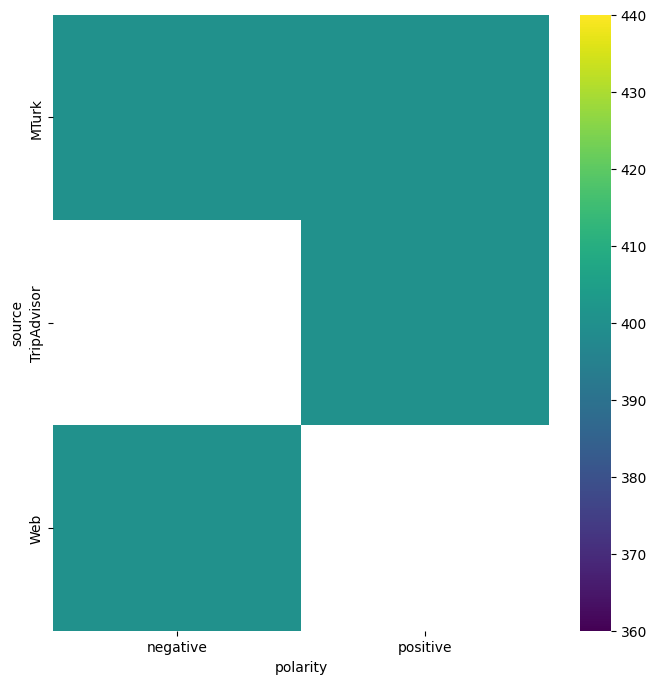

In [ ]:
# @title polarity vs source

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['source'].value_counts()
    for x_label, grp in data.groupby('polarity')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('polarity')
_ = plt.ylabel('source')

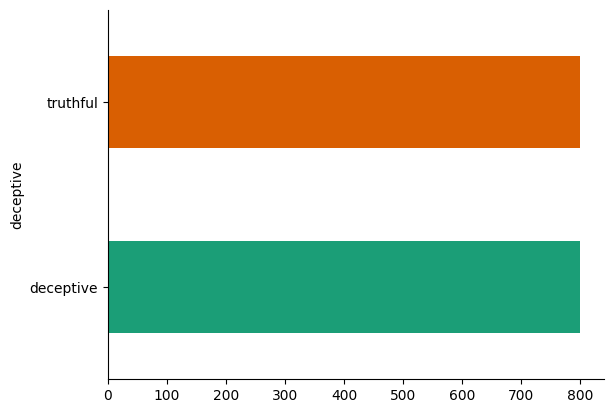

In [ ]:
# @title deceptive

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('deceptive').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
data['polarity'] = np.where(data['polarity']=='positive', 1, 0)
data['deceptive'] = np.where(data['deceptive']=='truthful', 1, 0)

In [ ]:
data.head()

,deceptive,hotel,polarity,source,text
0,1,conrad,1,TripAdvisor,We stayed for a one night getaway with family ...
1,1,hyatt,1,TripAdvisor,Triple A rate with upgrade to view room was le...
2,1,hyatt,1,TripAdvisor,This comes a little late as I'm finally catchi...
3,1,omni,1,TripAdvisor,The Omni Chicago really delivers on all fronts...
4,1,hyatt,1,TripAdvisor,I asked for a high floor away from the elevato...


In [ ]:
df = data.sample(frac=1)

In [ ]:
df.head()

,deceptive,hotel,polarity,source,text
622,0,hardrock,1,MTurk,Upon arriving to the Hard Rock Hotel in Chicag...
528,0,swissotel,1,MTurk,My family and I recently attended a wedding in...
1276,0,fairmont,0,MTurk,My stay at the Fairmont Chicago Millennium Hot...
458,0,hyatt,1,MTurk,I recently stayed at the Hyatt Regency in down...
679,0,monaco,1,MTurk,Hotel Monaco is simply amazing. I travel quite...


In [ ]:
df.describe()

,deceptive,polarity
count,1600.000000,1600.000000
mean,0.500000,0.500000
std,0.500156,0.500156
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.500000,0.500000
75%,1.000000,1.000000
max,1.000000,1.000000


In [ ]:
def create_class(c):
    if c['polarity'] == 1 and c['deceptive'] == 1:
        return [1,1]
    elif c['polarity'] == 1 and c['deceptive'] == 0:
        return [1,0]
    elif c['polarity'] == 0 and c['deceptive'] == 1:
        return [0,1]
    else:
        return [0,0]

def specific_class(c):
    if c['polarity'] == 1 and c['deceptive'] == 1:
        return "TRUE_POSITIVE"
    elif c['polarity'] == 1 and c['deceptive'] == 0:
        return "FALSE_POSITIVE"
    elif c['polarity'] == 0 and c['deceptive'] == 1:
        return "TRUE_NEGATIVE"
    else:
        return "FALSE_NEGATIVE"

data['final_class'] = data.apply(create_class, axis=1)
data['given_class'] = data.apply(specific_class, axis=1)

In [ ]:
data.head()

,deceptive,hotel,polarity,source,text,final_class,given_class
0,1,conrad,1,TripAdvisor,We stayed for a one night getaway with family ...,"[1, 1]",TRUE_POSITIVE
1,1,hyatt,1,TripAdvisor,Triple A rate with upgrade to view room was le...,"[1, 1]",TRUE_POSITIVE
2,1,hyatt,1,TripAdvisor,This comes a little late as I'm finally catchi...,"[1, 1]",TRUE_POSITIVE
3,1,omni,1,TripAdvisor,The Omni Chicago really delivers on all fronts...,"[1, 1]",TRUE_POSITIVE
4,1,hyatt,1,TripAdvisor,I asked for a high floor away from the elevato...,"[1, 1]",TRUE_POSITIVE


In [ ]:
# Import label encoder
from sklearn import preprocessing
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'species'.
data['given_class']= label_encoder.fit_transform(data['given_class'])

In [ ]:
data['given_class'].unique()

array([3, 1, 2, 0])

In [ ]:
data.head()

,deceptive,hotel,polarity,source,text,final_class,given_class
0,1,conrad,1,TripAdvisor,We stayed for a one night getaway with family ...,"[1, 1]",3
1,1,hyatt,1,TripAdvisor,Triple A rate with upgrade to view room was le...,"[1, 1]",3
2,1,hyatt,1,TripAdvisor,This comes a little late as I'm finally catchi...,"[1, 1]",3
3,1,omni,1,TripAdvisor,The Omni Chicago really delivers on all fronts...,"[1, 1]",3
4,1,hyatt,1,TripAdvisor,I asked for a high floor away from the elevato...,"[1, 1]",3


In [ ]:
Y = data['given_class']
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = to_categorical(encoded_Y)

In [ ]:
dummy_y

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [ ]:
textData = pd.DataFrame(list(data['text'])) # each row is one document; the raw text of the document should be in the 'text_data' column

In [ ]:
# initialize stemmer
import nltk
nltk.download('stopwords')
stemmer = snowballstemmer.EnglishStemmer()
# grab stopword list, extend it a bit, and then turn it into a set for later
#on ajoute des stopwords à notre list de mots indésirable
stop = stopwords.words('english')
stop.extend(['may','also','zero','one','two','three','four','five','six','seven','eight','nine','ten','across','among','beside','however','yet','within']+list(ascii_lowercase))
stoplist = stemmer.stemWords(stop)
stoplist = set(stoplist)
stop = set(sorted(stop + list(stoplist)))

In [ ]:
# remove characters and stoplist words, then generate dictionary of unique words
textData[0].replace('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\]',' ',inplace=True,regex=True)
wordlist = filter(None, " ".join(list(set(list(itertools.chain(*textData[0].str.split(' ')))))).split(" "))
data['stemmed_text_data'] = [' '.join(filter(None,filter(lambda word: word not in stop, line))) for line in textData[0].str.lower().str.split(' ')]

In [ ]:
# remove all words that don't occur at least 5 times and then stem the resulting docs
minimum_count = 1
str_frequencies = pd.DataFrame(list(Counter(filter(None,list(itertools.chain(*data['stemmed_text_data'].str.split(' '))))).items()),columns=['word','count'])
low_frequency_words = set(str_frequencies[str_frequencies['count'] < minimum_count]['word'])
data['stemmed_text_data'] = [' '.join(filter(None,filter(lambda word: word not in low_frequency_words, line))) for line in data['stemmed_text_data'].str.split(' ')]
data['stemmed_text_data'] = [" ".join(stemmer.stemWords(re.sub('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\]',' ', next_text).split(' '))) for next_text in data['stemmed_text_data']]

In [ ]:
data.head(n=2)

,deceptive,hotel,polarity,source,text,final_class,given_class,stemmed_text_data
0,1,conrad,1,TripAdvisor,We stayed for a one night getaway with family ...,"[1, 1]",3,stay night getaway famili thursday tripl aaa r...
1,1,hyatt,1,TripAdvisor,Triple A rate with upgrade to view room was le...,"[1, 1]",3,tripl rate upgrad view room less $ includ brea...


In [ ]:
lmtzr = WordNetLemmatizer()
w = re.compile("\w+",re.I)

def label_sentences(df, input_point):
    labeled_sentences = []
    list_sen = []
    for index, datapoint in df.iterrows():
        tokenized_words = re.findall(w,datapoint[input_point].lower())
        labeled_sentences.append(LabeledSentence(words=tokenized_words, tags=['SENT_%s' %index]))
        list_sen.append(tokenized_words)
    return labeled_sentences, list_sen

def train_doc2vec_model(labeled_sentences):
    model = Doc2Vec(min_count=1, window=9, vector_size=512, sample=1e-4, negative=5, workers=7)
    model.build_vocab(labeled_sentences)
    pretrained_weights = model.wv.vectors
    vocab_size, embedding_size = pretrained_weights.shape
    model.train(labeled_sentences, total_examples=vocab_size, epochs=400)

    return model

In [ ]:
textData = data['stemmed_text_data'].to_frame().reset_index()
sen, corpus = label_sentences(textData, 'stemmed_text_data')

In [ ]:
doc2vec_model = train_doc2vec_model(sen)

In [ ]:
doc2vec_model.save("doc2vec_model_opinion_corpus.d2v")

In [ ]:
doc2vec_model = Doc2Vec.load("doc2vec_model_opinion_corpus.d2v")

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

tfidf1 = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, ngram_range=(1,1))
result_train1 = tfidf1.fit_transform(corpus)

tfidf2 = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, ngram_range=(1,2))
result_train2 = tfidf2.fit_transform(corpus)

tfidf3 = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, ngram_range=(1,3))
result_train3 = tfidf3.fit_transform(corpus)

svd = TruncatedSVD(n_components=512, n_iter=40, random_state=34)
tfidf_data1 = svd.fit_transform(result_train1)
tfidf_data2 = svd.fit_transform(result_train2)
tfidf_data3 = svd.fit_transform(result_train3)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import spacy

nlp = spacy.load('en_core_web_sm')
temp_textData = pd.DataFrame(list(data['text']))

overall_pos_tags_tokens = []
overall_pos = []
overall_tokens = []
overall_dep = []

for i in range(1600):
    doc = nlp(temp_textData[0][i])
    given_pos_tags_tokens = []
    given_pos = []
    given_tokens = []
    given_dep = []
    for token in doc:
        output = "%s_%s" % (token.pos_, token.tag_)
        given_pos_tags_tokens.append(output)
        given_pos.append(token.pos_)
        given_tokens.append(token.tag_)
        given_dep.append(token.dep_)

    overall_pos_tags_tokens.append(given_pos_tags_tokens)
    overall_pos.append(given_pos)
    overall_tokens.append(given_tokens)
    overall_dep.append(given_dep)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

count = CountVectorizer(tokenizer=lambda i:i, lowercase=False)
pos_tags_data = count.fit_transform(overall_pos_tags_tokens).todense()
pos_data = count.fit_transform(overall_pos).todense()
tokens_data = count.fit_transform(overall_tokens).todense()
dep_data = count.fit_transform(overall_dep).todense()
min_max_scaler = MinMaxScaler()
normalized_pos_tags_data = min_max_scaler.fit_transform(np.array(pos_tags_data))
normalized_pos_data = min_max_scaler.fit_transform(np.array(pos_data))
normalized_tokens_data = min_max_scaler.fit_transform(np.array(tokens_data))
normalized_dep_data = min_max_scaler.fit_transform(np.array(dep_data))

final_pos_tags_data = np.zeros(shape=(1600, 512)).astype(np.float32)
final_pos_data = np.zeros(shape=(1600, 512)).astype(np.float32)
final_tokens_data = np.zeros(shape=(1600, 512)).astype(np.float32)
final_dep_data = np.zeros(shape=(1600, 512)).astype(np.float32)
final_pos_tags_data[:normalized_pos_tags_data.shape[0],:normalized_pos_tags_data.shape[1]] = normalized_pos_tags_data
final_pos_data[:normalized_pos_data.shape[0],:normalized_pos_data.shape[1]] = normalized_pos_data
final_tokens_data[:normalized_tokens_data.shape[0],:normalized_tokens_data.shape[1]] = normalized_tokens_data
final_dep_data[:normalized_dep_data.shape[0],:normalized_dep_data.shape[1]] = normalized_dep_data

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
maxlength = []
for i in range(0,len(sen)):
    maxlength.append(len(sen[i][0]))

print(max(maxlength))

370


In [ ]:
def vectorize_comments(df,d2v_model):
    y = []
    comments = []
    for i in range(0,df.shape[0]):
        label = 'SENT_%s' %i
        comments.append(d2v_model.docvecs[label])
    df['vectorized_comments'] = comments

    return df

textData = vectorize_comments(textData,doc2vec_model)
print (textData.head(2))

   index                                  stemmed_text_data  \
0      0  stay night getaway famili thursday tripl aaa r...   
1      1  tripl rate upgrad view room less $ includ brea...   

                                 vectorized_comments  
0  [-0.118991986, -0.14986695, 0.60840374, 0.2284...  
1  [-0.08801652, -0.066276036, 0.7668314, -0.2248...  


<ipython-input-34-2699a6802592>:6: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  comments.append(d2v_model.docvecs[label])


In [ ]:
textData

,index,stemmed_text_data,vectorized_comments
0,0,stay night getaway famili thursday tripl aaa r...,"[-0.118991986, -0.14986695, 0.60840374, 0.2284..."
1,1,tripl rate upgrad view room less $ includ brea...,"[-0.08801652, -0.066276036, 0.7668314, -0.2248..."
2,2,come littl late final catch review past sever ...,"[-0.36212987, -0.41721755, 0.9327369, -1.20992..."
3,3,omni chicago realli deliv front spacious room ...,"[0.8416326, -1.464486, 0.13991757, 2.165837, -..."
4,4,ask high floor away elev got room pleasant dec...,"[-0.54566354, -0.6184342, -0.0357086, 0.863982..."
...,...,...,...
1595,1595,problem start book intercontinent chicago onli...,"[0.59098244, 0.20949903, -0.37656534, 1.586401..."
1596,1596,amalfi hotel beauti websit interior decor wife...,"[-0.6214345, -0.12903471, -0.86980367, 0.60792..."
1597,1597,intercontinent chicago magnific mile outsid ho...,"[1.6144273, -1.6190404, 0.72076637, -0.3494107..."
1598,1598,palmer hous hilton look good pictur outsid act...,"[-0.26058796, -0.24127567, 0.7155238, 0.659590..."


In [ ]:
# load the whole embedding into memory
#embeddings_index = dict()
#f = open('glove/glove.6B.300d.txt')
#for line in f:
#    values = line.split()
#    word = values[0]
#    coefs = np.asarray(values[1:], dtype='float32')
#    embeddings_index[word] = coefs
#f.close()
#print('Loaded %s word vectors.' % len(embeddings_index))

In [ ]:
#from nltk.corpus import stopwords

#glove_data = np.zeros(shape=(1600, 800, 512)).astype(np.float32)
#temp_textData = data['text'].to_frame().reset_index()
#sen2, corpus2 = label_sentences(temp_textData, 'text')
#stop_words = set(stopwords.words('english'))
#test_word = np.zeros(512).astype(np.float32)
#final_matrix = np.zeros(512).astype(np.float32)
#final_sizes = []

#count = True

#for i in range(1600):
#    for j in sen2[i][0]:
#        if j in embeddings_index and j not in stop_words:
#            test_word[:300] = embeddings_index[j]
#            if count == True:
#                final_matrix = test_word
#                count = False
#            else:
#                final_matrix = np.vstack((final_matrix, test_word))

#    final_sizes.append(final_matrix.shape[0])
#    final_matrix = np.zeros(512).astype(np.float32)
#    glove_data[i,:final_matrix.shape[0],:] = final_matrix
#    count = True

#print(max(final_sizes))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate,GridSearchCV
#dummy_y=data['given_class']
X_train, X_test, y_train, y_test = train_test_split(textData["vectorized_comments"].T.tolist(),
                                                                     dummy_y,
                                                                     test_size=0.1,
                                                                     random_state=56)

In [ ]:
X = np.array(textData["vectorized_comments"].T.tolist()).reshape((1,1600,512))
y = np.array(dummy_y).reshape((1600,4))
X_train2 = np.array(X_train).reshape((1,1440,512))
y_train2 = np.array(y_train).reshape((1,1440,4))
X_test2 = np.array(X_test).reshape((1,160,512))
y_test2 = np.array(y_test).reshape((1,160,4))

In [ ]:
from sklearn.model_selection import StratifiedKFold
Xtemp = textData["vectorized_comments"].T.tolist()
ytemp = data['given_class']
training_indices = []
testing_indices = []

skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(Xtemp, ytemp)

for train_index, test_index in skf.split(Xtemp, ytemp):
    training_indices.append(train_index)
    testing_indices.append(test_index)

In [ ]:
def extractTrainingAndTestingData(givenIndex):
    X_train3 = np.zeros(shape=(1440, max(maxlength)+10, 512)).astype(np.float32)
    Y_train3 = np.zeros(shape=(1440, 4)).astype(np.float32)
    X_test3 = np.zeros(shape=(160, max(maxlength)+10, 512)).astype(np.float32)
    Y_test3 = np.zeros(shape=(160, 4)).astype(np.float32)

    empty_word = np.zeros(512).astype(np.float32)

    count_i = 0
    for i in training_indices[givenIndex]:
        len1 = len(sen[i][0])
        average_vector1 = np.zeros(512).astype(np.float32)
        average_vector2 = np.zeros(512).astype(np.float32)
        average_vector3 = np.zeros(512).astype(np.float32)
        for j in range(max(maxlength)+10):
            if j < len1:
                X_train3[count_i,j,:] = doc2vec_model[sen[i][0][j]]
                average_vector1 += result_train1[i, tfidf1.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
                average_vector2 += result_train2[i, tfidf2.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
                average_vector3 += result_train3[i, tfidf3.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
            #elif j >= len1 and j < len1 + 379:
            #    X_train3[count_i,j,:] = glove_data[i, j-len1, :]
            elif j == len1:
                X_train3[count_i,j,:] = tfidf_data1[i]
            elif j == len1 + 1:
                X_train3[count_i,j,:] = tfidf_data2[i]
            elif j == len1+2:
                X_train3[count_i,j,:] = tfidf_data3[i]
            elif j == len1+3:
                X_train3[count_i,j,:] = average_vector1
            elif j == len1+4:
                X_train3[count_i,j,:] = average_vector2
            elif j == len1+5:
                X_train3[count_i,j,:] = average_vector3
            elif j == len1+6:
                X_train3[count_i,j,:] = final_pos_tags_data[i]
            elif j == len1+7:
                X_train3[count_i,j,:] = final_pos_data[i]
            elif j == len1+8:
                X_train3[count_i,j,:] = final_tokens_data[i]
            elif j == len1+9:
                X_train3[count_i,j,:] = final_dep_data[i]
            else:
                X_train3[count_i,j,:] = empty_word

        Y_train3[count_i,:] = dummy_y[i]
        count_i += 1


    count_i = 0
    for i in testing_indices[givenIndex]:
        len1 = len(sen[i][0])
        average_vector1 = np.zeros(512).astype(np.float32)
        average_vector2 = np.zeros(512).astype(np.float32)
        average_vector3 = np.zeros(512).astype(np.float32)
        for j in range(max(maxlength)+10):
            if j < len1:
                X_test3[count_i,j,:] = doc2vec_model[sen[i][0][j]]
                average_vector1 += result_train1[i, tfidf1.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
                average_vector2 += result_train2[i, tfidf2.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
                average_vector3 += result_train3[i, tfidf3.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
            #elif j >= len1 and j < len1 + 379:
            #    X_test3[count_i,j,:] = glove_data[i, j-len1, :]
            elif j == len1:
                X_test3[count_i,j,:] = tfidf_data1[i]
            elif j == len1 + 1:
                X_test3[count_i,j,:] = tfidf_data2[i]
            elif j == len1+2:
                X_test3[count_i,j,:] = tfidf_data3[i]
            elif j == len1+3:
                X_test3[count_i,j,:] = average_vector1
            elif j == len1+4:
                X_test3[count_i,j,:] = average_vector2
            elif j == len1+5:
                X_test3[count_i,j,:] = average_vector3
            elif j == len1+6:
                X_test3[count_i,j,:] = final_pos_tags_data[i]
            elif j == len1+7:
                X_test3[count_i,j,:] = final_pos_data[i]
            elif j == len1+8:
                X_test3[count_i,j,:] = final_tokens_data[i]
            elif j == len1+9:
                X_test3[count_i,j,:] = final_dep_data[i]
            else:
                X_test3[count_i,j,:] = empty_word

        Y_test3[count_i,:] = dummy_y[i]
        count_i += 1

    return X_train3, X_test3, Y_train3, Y_test3


In [ ]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=9, padding='same', activation='relu', input_shape=(max(maxlength)+10,512)))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(filters=128, kernel_size=7, padding='same', activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(Dropout(0.25))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.25))
#model.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'))
#model.add(Dropout(0.25))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.25))

#model.add(Bidirectional(LSTM(50, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(50, dropout=0.25, recurrent_dropout=0.2)))
model.add(Dense(4, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint

final_accuracies = []

filename = 'weights.best.from_scratch%s.hdf5' % 9
checkpointer = ModelCheckpoint(filepath=filename, verbose=1, save_best_only=True)
X_train3, X_test3, Y_train3, Y_test3 = extractTrainingAndTestingData(9)

In [ ]:
history = model.fit(X_train3, Y_train3, epochs=15, batch_size=512, callbacks=[checkpointer], validation_data=(X_test3, Y_test3), verbose=1)

In [ ]:
model.evaluate(X_test3, Y_test3)

In [ ]:
import matplotlib.pyplot as plt

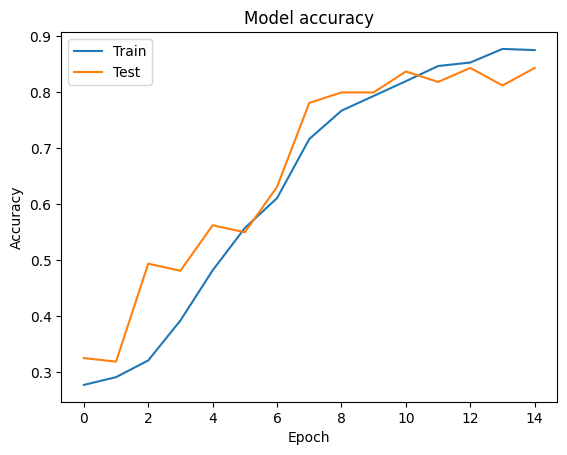

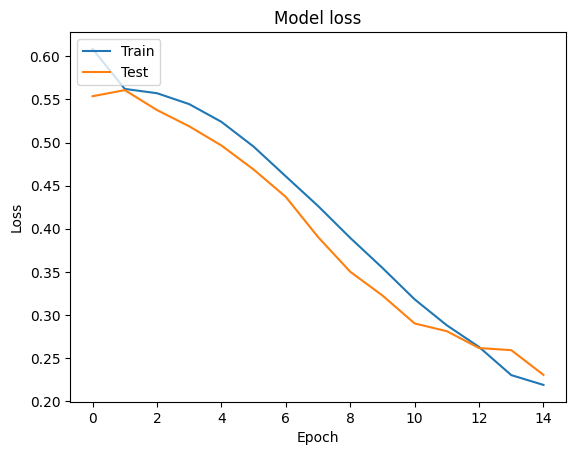

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.load_weights(filename)

In [ ]:
for i in range(10):
    filename = 'weights.best.from_scratch%s.hdf5' % i
    checkpointer = ModelCheckpoint(filepath=filename, verbose=1, save_best_only=True)
    X_train3, X_test3, Y_train3, Y_test3 = extractTrainingAndTestingData(i)
    model.fit(X_train3, Y_train3, epochs=10, batch_size=512, callbacks=[checkpointer], validation_data=(X_test3, Y_test3))
    model.load_weights(filename)
    predicted = np.rint(model.predict(X_test3))
    final_accuracies.append(accuracy_score(Y_test3, predicted))
    print(accuracy_score(Y_test3, predicted))

Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 0.1954 - accuracy: 0.8931
Epoch 1: val_loss improved from inf to 0.17357, saving model to weights.best.from_scratch0.hdf5
3/3 [==============================] - 4s 1s/step - loss: 0.1954 - accuracy: 0.8931 - val_loss: 0.1736 - val_accuracy: 0.9000
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 0.1732 - accuracy: 0.9146
Epoch 2: val_loss improved from 0.17357 to 0.17128, saving model to weights.best.from_scratch0.hdf5
3/3 [==============================] - 3s 1s/step - loss: 0.1732 - accuracy: 0.9146 - val_loss: 0.1713 - val_accuracy: 0.8875
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 0.1555 - accuracy: 0.9215
Epoch 3: val_loss improved from 0.17128 to 0.15955, saving model to weights.best.from_scratch0.hdf5
3/3 [==============================] - 4s 2s/step - loss: 0.1555 - accuracy: 0.9215 - val_loss: 0.1596 - val_accuracy: 0.9187
Epoch 4/10
3/3 [==============================] - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.9660
Epoch 2: val_loss improved from 0.05943 to 0.05009, saving model to weights.best.from_scratch1.hdf5
3/3 [==============================] - 3s 1s/step - loss: 0.0973 - accuracy: 0.9660 - val_loss: 0.0501 - val_accuracy: 1.0000
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 0.0838 - accuracy: 0.9729
Epoch 3: val_loss improved from 0.05009 to 0.04475, saving model to weights.best.from_scratch1.hdf5
3/3 [==============================] - 3s 1s/step - loss: 0.0838 - accuracy: 0.9729 - val_loss: 0.0448 - val_accuracy: 1.0000
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 0.0726 - accuracy: 0.9806
Epoch 4: val_loss improved from 0.04475 to 0.04381, saving model to weights.best.from_scratch1.hdf5
3/3 [==============================] - 3s 1s/step - loss: 0.0726 - accuracy: 0.9806 - val_loss: 0.0438 - val_accuracy: 1.0000
Epoch 5/10
3/3 [==============================] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - ETA: 0s - loss: 0.0407 - accuracy: 0.9917
Epoch 2: val_loss improved from 0.04883 to 0.04584, saving model to weights.best.from_scratch2.hdf5
3/3 [==============================] - 3s 1s/step - loss: 0.0407 - accuracy: 0.9917 - val_loss: 0.0458 - val_accuracy: 0.9875
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 0.0381 - accuracy: 0.9924
Epoch 3: val_loss improved from 0.04584 to 0.04495, saving model to weights.best.from_scratch2.hdf5
3/3 [==============================] - 3s 995ms/step - loss: 0.0381 - accuracy: 0.9924 - val_loss: 0.0449 - val_accuracy: 0.9875
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 0.0356 - accuracy: 0.9931
Epoch 4: val_loss did not improve from 0.04495
3/3 [==============================] - 3s 959ms/step - loss: 0.0356 - accuracy: 0.9931 - val_loss: 0.0453 - val_accuracy: 0.9875
Epoch 5/10
3/3 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9944
Epoch 5: val

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 0.9951
Epoch 2: val_loss improved from 0.01575 to 0.01408, saving model to weights.best.from_scratch3.hdf5
3/3 [==============================] - 3s 1s/step - loss: 0.0240 - accuracy: 0.9951 - val_loss: 0.0141 - val_accuracy: 1.0000
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 0.0222 - accuracy: 0.9958
Epoch 3: val_loss improved from 0.01408 to 0.01317, saving model to weights.best.from_scratch3.hdf5
3/3 [==============================] - 3s 1s/step - loss: 0.0222 - accuracy: 0.9958 - val_loss: 0.0132 - val_accuracy: 1.0000
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 0.0215 - accuracy: 0.9951
Epoch 4: val_loss improved from 0.01317 to 0.01258, saving model to weights.best.from_scratch3.hdf5
3/3 [==============================] - 3s 1s/step - loss: 0.0215 - accuracy: 0.9951 - val_loss: 0.0126 - val_accuracy: 1.0000
Epoch 5/10
3/3 [==============================] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 6s 2s/step - loss: 0.0139 - accuracy: 0.9979 - val_loss: 0.0099 - val_accuracy: 1.0000
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9986
Epoch 2: val_loss improved from 0.00989 to 0.00950, saving model to weights.best.from_scratch4.hdf5
3/3 [==============================] - 7s 3s/step - loss: 0.0133 - accuracy: 0.9986 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.9986
Epoch 3: val_loss improved from 0.00950 to 0.00922, saving model to weights.best.from_scratch4.hdf5
3/3 [==============================] - 6s 3s/step - loss: 0.0126 - accuracy: 0.9986 - val_loss: 0.0092 - val_accuracy: 1.0000
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9986
Epoch 4: val_loss improved from 0.00922 to 0.00895, saving model to weights.best.from_scratch4.hdf5
3/3 [==============================] - 5s 2s/s

In [ ]:
print(sum(final_accuracies) / len(final_accuracies))